In [1]:
import sys 

import numpy as np

import torch

### Paths zone

In [2]:
# Paths for sys

# Path to the WatchMaL folder
base_path         = "/sps/t2k/eleblevec/updated_watchmal/WatChMaL"

# Path to the "pure" .root containing the events
root_file_path     = "/sps/t2k/eleblevec/files_for_new_watchmal/datasets/root_datasets/output_test.root"
#root_file_path     = "/sps/t2k/lperisse/skynet_Lorenzo/Datasets/WCSIM_outputs/wcsim112_UnifVtx_10MeV_DNoff_POST_short.root"

# Path to save the .pt containing the graphs
graph_dataset_path = "/sps/t2k/eleblevec/cc_net/grant/src/Data"
#graph_dataset_path = "/pbs/home/e/elebleve/grant/src/Data"

In [3]:
sys.path.append(base_path)

## Setting dataset and dataloader

In [4]:
from watchmal.dataset.gnn.graph_in_memory_dataset import GraphInMemoryDataset

#from Datasets.utils import get_dataloader
from  watchmal.dataset.gnn.transformations import Normalize

import torch_geometric.transforms as T
from torch_geometric.transforms import KNNGraph

In [5]:
# Parameters of all the transformations
tank_radius = 6480. * 0.5
tank_halfz  = 6575.1 * 0.5
tank_timing = 1000.
vtx_timing  = 150.

n_neighbors = 10


### Instantiating the transformion classes 
knn = KNNGraph(k=n_neighbors)

pre_trf_compose = T.Compose([knn])

feat_norm  = torch.tensor([[tank_radius, tank_radius, tank_halfz, tank_timing], [-tank_radius, -tank_radius, -tank_halfz, 0.]], dtype=torch.float32)
label_norm = torch.tensor([[tank_radius, tank_radius, tank_halfz, vtx_timing],  [-tank_radius, -tank_radius, -tank_halfz, 0.]], dtype=torch.float32)
normalize = Normalize(feat_norm=feat_norm, label_norm=None)

trf_compose = T.Compose([normalize])

/sps/t2k/eleblevec/updated_watchmal/WatChMaL/watchmal/dataset/gnn/transformations.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.feat_norm = torch.tensor(self.feat_norm)


In [6]:
# Will be apply to the features in the same order as train_keys
# (0, -(1 + 1e-12) Equivalent to "no normalization"

# Graph Transform parameters
# feat_norm = torch.tensor([[1000., 1000., 1000. , 5., 2000.], [-1000., -1000., -1000., -5., 0.]], dtype=torch.float32)
# label_norm = torch.tensor([0.5, 0.4], dtype=torch.float32)
#label_norm = None


# Graph creation and training parameters 
train_keys = ['hitx', 'hity', 'hitz', 'time']
label_keys = ['eventType']
edge_keys  = ['hitx', 'hity', 'hitz']

graph_dataset_path = "/sps/t2k/eleblevec/cc_net/grant/src/Data/christine_datasets/beta_mode"
tree_name          = "root_event"  # "root_event"
dataset_config = {
    'root_file_path': root_file_path,
    'graph_dataset_path': graph_dataset_path,
    'tree_name': tree_name,
    'train_keys': train_keys,
    'label_keys': label_keys,
    'edge_keys': edge_keys,
    'to_torch_tensor': True,
    'beta_mode': True,
    'verbose': 0,
    'watchmal': False
}


dataset = GraphInMemoryDataset(
    config=dataset_config,
    pre_filter=None,
    pre_transform=pre_trf_compose,
    transform=trf_compose
)

In [7]:
len(dataset)

26

In [11]:
dataset[0].x.shape, dataset[0].y.shape

(torch.Size([2431, 4]), torch.Size([1]))

In [12]:
dataset[0].y

tensor([1.])

In [13]:
dataset.x.max(dim=-2), dataset.x.min(dim=-2)

(torch.return_types.max(
 values=tensor([3253.6257, 3250.8821, 3296.4712, 1898.2000]),
 indices=tensor([    8,    68,     0, 13428])),
 torch.return_types.min(
 values=tensor([-3252.0569, -3252.4451, -3296.4712,   550.9000]),
 indices=tensor([   71,   589,     1, 27626])))

À vérifier : Est-ce qu'il y a une arrête qui relie le noeud à lui même ?

In [14]:
dataset[0].edge_index[1, :100]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9])

#### Troubles when num_workers > 0. Seems to be related to the cluster.
See 
https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813/56  
https://unix.stackexchange.com/questions/348315/nfs-mount-device-or-resource-busy

  might be usefull : ! echo $TMPDIR  

  __Update__ : 25/01/2024 : Indeed, it's related to the cluster s way of handling notebooks, no problem when lauching SLURM job with multiple workers (tested on CPU and GPU)

In [15]:
loading_config = {
    'batch_size': 8,
    "shuffle": True,
    'num_workers': 0,
    'drop_last': True
}

loader = get_dataloader(dataset, loading_config)
loader.num_workers

itr = iter(loader)

In [16]:
# Caution : YOU MAY NEED TO REDUCE THE BATCH SIZE IF YOU'RE IN BETA_MODE=TRUE
data = next(itr)
data

DataBatch(x=[21472, 4], y=[8], pos=[21472, 3], edge_index=[2, 214720], batch=[21472], ptr=[9])

### Setting model, loss_fn and optimizer

In [17]:
import torch 

from Models.BaseGCN import GCN
from Models.ResGated import ResGateConv_v2

In [22]:
model = GCN(
    in_feat=4,
    h_feat=8,
    num_classes=1
) # A "new" model

# model = ExecMyEdgeConv(
#     dataset,
#     nb_conv_layers=2,
#     nb_hidden_layers=2,
#     kernels=[32, 32],
# ) # grant_v1

# model = MyEdgeConv(
#     dataset,
#     nb_conv_layers=2,
#     nb_hidden_layers=2,
#     kernels=[16, 16],
#) # grant_v1_cleaned

# model = ResGateConv_v2(
#     in_channels=4,
#     conv_in_channels=[16, 32, 64, 128],
#     linear_out_features=[64, 32, 2]
# ) # grant_v2, please use this one now

print(model)
sum(p.numel() for p in model.parameters() if p.requires_grad)

GCN(
  (conv1): GCNConv(4, 8)
  (conv2): GCNConv(8, 16)
  (conv3): GCNConv(16, 32)
  (conv4): GCNConv(32, 64)
  (lin): Linear(in_features=64, out_features=1, bias=True)
)


2905

### Training & testing

In [25]:
from Tasks.graph_basic_train import train

In [26]:
traintest_config = {
    'epochs': 5,
    'print_every': 15, # print every n batches
    'flatten_model_output': True
}

In [27]:
loss_fn = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)

for t in range(traintest_config['epochs']):

    if t % 5 == 0:
        print(f"Epoch {t+1}\n-------------------------------")
        
    train(loader, model, loss_fn, optimizer, **traintest_config)

Epoch 1
-------------------------------
The loss is : 0.7164809703826904 [0 / 24], batch_size: 8


The loss is : 0.6235530972480774 [0 / 24], batch_size: 8
The loss is : 0.5402531623840332 [0 / 24], batch_size: 8
The loss is : 0.476769357919693 [0 / 24], batch_size: 8
The loss is : 0.4119681715965271 [0 / 24], batch_size: 8


#### Évaluation avec une séparation (non-optimale) à 0.5 

In [28]:
import matplotlib.pyplot as plt

from Tasks.graph_basic_test import test

In [29]:
test_config = {
    'threshold': 0.5,
    'flatten_model_output': True,    
}

test(loader, model, loss_fn, **test_config)

Nombre de données utilisées pour le test : 24
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.348738 



(array([3., 0., 1., 0., 2., 8., 2., 3., 2., 3.]),
 array([0.80324852, 0.81613338, 0.82901818, 0.84190297, 0.85478783,
        0.86767268, 0.88055748, 0.89344227, 0.90632713, 0.91921198,
        0.93209678]),
 <BarContainer object of 10 artists>)

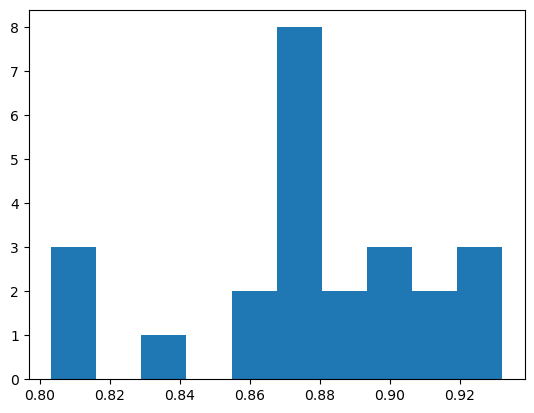

In [30]:
outs = []
for batch in loader:
    outs.append(torch.flatten((model(batch))).detach().numpy())

outs = np.array(outs).reshape(-1)
plt.hist(outs)

## Comparing with the output of an untrained model

In [31]:
model_2 = GCN(
    in_feat=4,
    h_feat=8,
    num_classes=1
) # A "new" model

(array([3., 1., 2., 2., 0., 2., 3., 5., 4., 2.]),
 array([-0.18609372, -0.15579985, -0.12550598, -0.09521211, -0.06491824,
        -0.03462438, -0.00433051,  0.02596336,  0.05625723,  0.0865511 ,
         0.11684497]),
 <BarContainer object of 10 artists>)

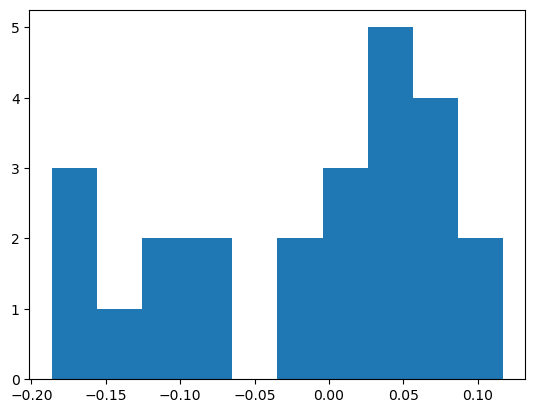

In [32]:
outs = []
for batch in loader:
    outs.append(torch.flatten((model_2(batch))).detach().numpy())

outs = np.array(outs).reshape(-1)
plt.hist(outs)

## Code for debug

(Do not execute if only following the tutoria)

for batch_data in loader:
    
    data = batch_data[0]

    print(f"The batch       : {batch_data} \n")
    print(f"Number of nodes : {data.x} \n")
    print(f"Data.x type     : {data.x.type()} \n")
    print(f"Data.x shape    : {data.x.shape} \n")
    print(f"Label type      : {data.y.type()} \n")
    
    # print(f'Number of nodes: {data.num_nodes}')
    # print(f'Number of edges: {data.num_edges}')
    # print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    # print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    # print(f'Has self-loops: {data.has_self_loops()}')
    # print(f'Is undirected: {data.is_undirected()}')
    break